<a href="https://colab.research.google.com/github/bugbreaker18/OCR/blob/main/carlicenseplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print("Python version:", sys.version)

Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving carlicenseplate.zip to carlicenseplate.zip


In [ ]:
import zipfile
import os

# Specify the path to the uploaded zip file
zip_path = 'carlicenseplate.zip'

# Specify the target directory for extraction
target_directory = 'data'

# Create the target directory if it doesn't exist
os.makedirs(target_directory, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)

print('Extraction complete.')


Extraction complete.


In [ ]:
!pip install xmltodict
!pip install split-folders
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=16c08325a3d156051019e2e8d8937d2b5dcd5afa38ea8b81c4d004ce5f0c3a09
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 12.7 MB/s eta 0:00:00


In [ ]:

import os

import numpy as np
import cv2
import uuid
import time
import pandas as pd

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders
import easyocr
import PIL
import copy

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
matplotlib.use('Agg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

In [ ]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [ ]:
img_names=[]
annotations=[]
for dirname, _, filenames in os.walk("/content/data"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]==("png" or "jpg"):
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annotations.append(filename)

img_names[:10]

['Cars5.png',
 'Cars428.png',
 'Cars359.png',
 'Cars268.png',
 'Cars169.png',
 'Cars313.png',
 'Cars293.png',
 'Cars270.png',
 'Cars83.png',
 'Cars0.png']

In [ ]:
annotations[:10]

['Cars20.xml',
 'Cars90.xml',
 'Cars418.xml',
 'Cars25.xml',
 'Cars296.xml',
 'Cars155.xml',
 'Cars251.xml',
 'Cars372.xml',
 'Cars97.xml',
 'Cars340.xml']

In [ ]:
path_annotations="/content/data/annotations/*.xml"

for item in glob.glob(path_annotations):
    tree = ET.parse(item)

    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)

            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)

classes = ['license']

In [ ]:
df=pd.DataFrame(dataset)
df

,file,width,height,xmin,ymin,xmax,ymax
0,Cars20.png,400,244,18,135,48,152
1,Cars90.png,400,300,77,204,101,225
2,Cars418.png,400,225,99,70,303,155
3,Cars25.png,400,225,177,139,216,159
4,Cars296.png,400,318,163,158,234,196
...,...,...,...,...,...,...,...
466,Cars308.png,400,300,159,221,237,241
467,Cars431.png,400,192,55,82,343,147
468,Cars262.png,400,301,243,184,285,205
469,Cars232.png,400,300,175,174,228,201


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    471 non-null    object
 1   width   471 non-null    int64 
 2   height  471 non-null    int64 
 3   xmin    471 non-null    int64 
 4   ymin    471 non-null    int64 
 5   xmax    471 non-null    int64 
 6   ymax    471 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 25.9+ KB


Populating the interactive namespace from numpy and matplotlib
433


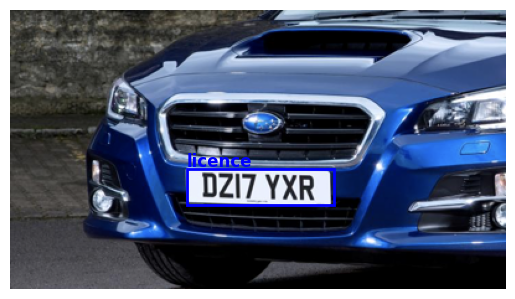

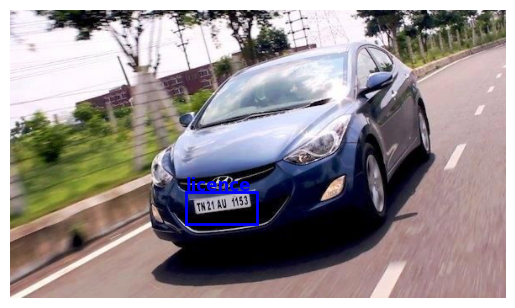

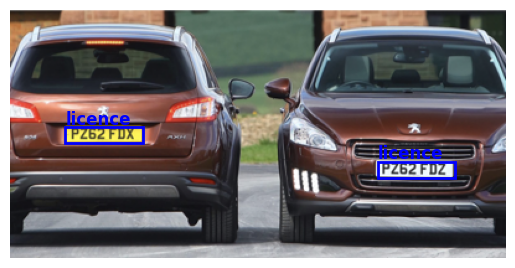

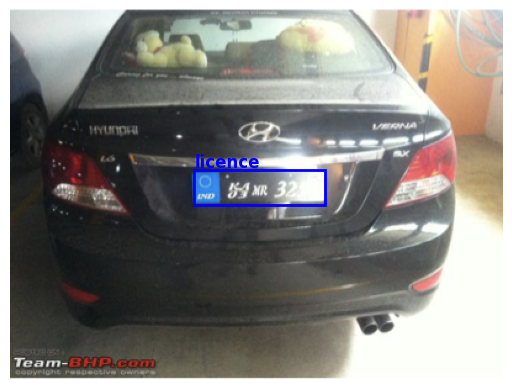

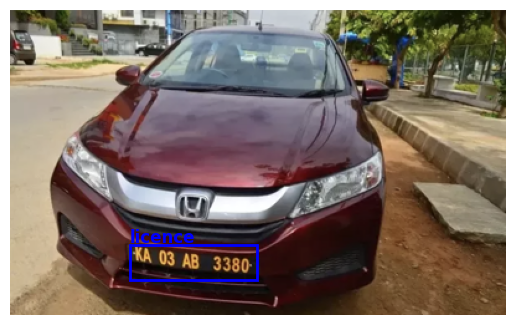

In [ ]:
%pylab inline

def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10

    if seed:
        rnd.seed(seed)

    random_photos = rnd.sample(photos, n)

    for image_path in random_photos:

        with Image.open(image_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)
            ax.axis(False)

            for i, file in enumerate(df.file):
                if file in image_path:
                    x1,y1,x2,y2=list(df.iloc[i, -4:])

                    mpatch=mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor='b',facecolor="none",lw=2,)
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate('licence', (rx, ry-2), color='blue', weight='bold', fontsize=12, ha='left', va='baseline')

photos_path = "/content/data/images/*.png"
photos_list = glob.glob(photos_path)
print(len(photos_list))
print_random_images(photos_list)

In [ ]:
from pathlib import Path

# Create the output directory for annotations
annotations_path = Path("/content/working/annotations")
annotations_path.mkdir(parents=True, exist_ok=True)

x_pos = []
y_pos = []
frame_width = []
frame_height = []

previous_filename = None

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])

    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])

    x = (xmin + xmax) / 2 / width
    y = (ymin + ymax) / 2 / height
    width = (xmax - xmin) / width
    height = (ymax - ymin) / height

    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)

    txt = f'0 {x} {y} {width} {height}\n'

    # Determine save type
    save_type = 'a+' if current_filename == previous_filename else 'w'

    with open(annotations_path / f"{current_filename}.txt", save_type) as f:
        f.write(txt)

    previous_filename = current_filename

df['x_pos'] = x_pos
df['y_pos'] = y_pos
df['frame_width'] = frame_width
df['frame_height'] = frame_height

df


,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
0,Cars20.png,400,244,18,135,48,152,0.082500,0.588115,0.075000,0.069672
1,Cars90.png,400,300,77,204,101,225,0.222500,0.715000,0.060000,0.070000
2,Cars418.png,400,225,99,70,303,155,0.502500,0.500000,0.510000,0.377778
3,Cars25.png,400,225,177,139,216,159,0.491250,0.662222,0.097500,0.088889
4,Cars296.png,400,318,163,158,234,196,0.496250,0.556604,0.177500,0.119497
...,...,...,...,...,...,...,...,...,...,...,...
466,Cars308.png,400,300,159,221,237,241,0.495000,0.770000,0.195000,0.066667
467,Cars431.png,400,192,55,82,343,147,0.497500,0.596354,0.720000,0.338542
468,Cars262.png,400,301,243,184,285,205,0.660000,0.646179,0.105000,0.069767
469,Cars232.png,400,300,175,174,228,201,0.503750,0.625000,0.132500,0.090000


In [ ]:
input_folder = Path("/content/data")
output_folder = Path("yolov5/data/Plate_recognition")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 866 files [00:01, 548.98 files/s]

Moving files finished.


In [ ]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")


walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There are 2 directiories and 0 files in '/content/data' folder 
There are 0 directiories and 433 files in '/content/data/images' folder 
There are 0 directiories and 433 files in '/content/data/annotations' folder 

There are 2 directiories and 0 files in 'yolov5/data/Plate_recognition' folder 
There are 2 directiories and 0 files in 'yolov5/data/Plate_recognition/val' folder 
There are 0 directiories and 87 files in 'yolov5/data/Plate_recognition/val/images' folder 
There are 0 directiories and 87 files in 'yolov5/data/Plate_recognition/val/annotations' folder 
There are 2 directiories and 0 files in 'yolov5/data/Plate_recognition/train' folder 
There are 0 directiories and 346 files in 'yolov5/data/Plate_recognition/train/images' folder 
There are 0 directiories and 346 files in 'yolov5/data/Plate_recognition/train/annotations' folder 


In [ ]:
import yaml

yaml_file = 'yolov5/data/plates.yaml'

yaml_data = dict(
    path = "data/Plate_recognition",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

In [ ]:
# Clone the repository
!git clone https://github.com/ultralytics/yolov5.git

# Move to the cloned directory
%cd yolovplz

# Install the requirements
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15921, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15921 (delta 16), reused 22 (delta 8), pack-reused 15880
Receiving objects: 100% (15921/15921), 14.66 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (10911/10911), done.
[Errno 2] No such file or directory: 'yolovplz'
/content/yolovplz


In [35]:
!rm -r /content/yolovplz  # Remove the incorrect directory if it exists
!git clone https://github.com/ultralytics/yolov5.git /content/yolovplz

Cloning into '/content/yolovplz'...
remote: Enumerating objects: 15921, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 15921 (delta 16), reused 24 (delta 9), pack-reused 15880
Receiving objects: 100% (15921/15921), 14.60 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (10915/10915), done.


In [36]:
start_time = timer()


# Navigate to the correct directory
%cd /content/yolov5

# Run the training command
!python train.py --workers 2 --img 640 --batch 16 --epochs 100 --data "data/plates.yaml" --weights yolov5s.pt --device {device} --cache


end_time = timer()

print(f'Training time: {(end_time-start_time):.2f}')

/content/yolovplz
python3: can't open file '/content/yolov5/train.py': [Errno 2] No such file or directory
Training time: 0.11
